In [1]:
from alphablokus.analysis.read_mcts_trace import iter_trace_log, find_sole_log, filter_by_search_id, get_search_ids
from alphablokus.analysis.mcts_analysis import array_index_top_k

import matplotlib.pyplot as plt
import numpy as np

In [14]:
all_logs = list(iter_trace_log("/tmp/alphablokus_trace", rows=100000))

Reading file into memory...
Done reading file into memory.
Parsing lines...


KeyboardInterrupt: 

In [28]:
recent_search_ids = get_search_ids(all_logs, 24)
search_id = recent_search_ids[-1]

In [ ]:
for search_id in recent_search_ids:
    logs = filter_by_search_id(all_logs, search_id)
    started_search = find_sole_log(logs, lambda t: t.type == "started_search")
    search_root_id = started_search.root_node_id
    created_root_node = find_sole_log(logs, lambda t: t.type == "created_node" and t.node_id == search_root_id)
    selected_move_to_play = find_sole_log(logs, lambda t: t.type == "selected_move_to_play")
    selected_move_by_ucb = [log for log in logs if log.type == "selected_move_by_ucb"][-1]
    root_network_eval_result = find_sole_log(logs, lambda t: t.type == "network_eval_result" and t.node_id == search_root_id)

    # print(root_network_eval_result.value)

    # print("Visit counts", sorted(selected_move_to_play.children_visit_counts, reverse=True)[:100])

    # # Percent of rollouts on nodes with >1 visit
    # p = sum(n for n in selected_move_to_play.children_visit_counts if n > 1) / sum(selected_move_to_play.children_visit_counts)
    # print("Valid moves: ", len(selected_move_to_play.children_visit_counts))
    # print("% visits with >1 visit:", p * 100)
    # print("% nodes with 0 visits:", sum(1 for n in selected_move_to_play.children_visit_counts if n == 0) / len(selected_move_to_play.children_visit_counts) * 100)
    # print(started_search.state["player"])

    selected_array_index = selected_move_to_play.array_index
    print("MOVE")
    print("Valid moves:", len(selected_move_to_play.children_visit_counts))
    print("Num with prior > 5e-4:", sum(1 for p in selected_move_to_play.children_prior_probabilities if p > 5e-4))
    print("Num with prior > 1e-3:", sum(1 for p in selected_move_to_play.children_prior_probabilities if p > 1e-3))
    print("Prior prob of selected move", selected_move_to_play.children_prior_probabilities[selected_array_index])

MOVE
Valid moves: 58
Prior prob of selected move 0.24184568
Percent high prior: 1.0
MOVE
Valid moves: 58
Prior prob of selected move 0.24184844
Percent high prior: 1.0
MOVE
Valid moves: 58
Prior prob of selected move 0.2418413
Percent high prior: 1.0
MOVE
Valid moves: 185
Prior prob of selected move 0.7070205
Percent high prior: 1.0
MOVE
Valid moves: 185
Prior prob of selected move 0.7056454
Percent high prior: 1.0
MOVE
Valid moves: 185
Prior prob of selected move 0.7045924
Percent high prior: 1.0
MOVE
Valid moves: 565
Prior prob of selected move 0.7998993
Percent high prior: 0.1929203539823009
MOVE
Valid moves: 565
Prior prob of selected move 0.7905337
Percent high prior: 0.1752212389380531
MOVE
Valid moves: 565
Prior prob of selected move 0.7832485
Percent high prior: 0.20530973451327433
MOVE
Valid moves: 783
Prior prob of selected move 0.4581898
Percent high prior: 0.26181353767560667
MOVE
Valid moves: 784
Prior prob of selected move 0.530581
Percent high prior: 0.375
MOVE
Valid mov

In [ ]:
# Based on final visit counts
array_index_top_k(selected_move_by_ucb.children_visit_counts, created_root_node.array_index_to_move_index)

# Interesting ones:
# 22532 - i picked it
# 5554 - good
# 6223 - good

[(267, 22532, 72),
 (103, 6223, 33),
 (88, 5554, 18),
 (268, 22617, 18),
 (239, 21593, 17),
 (56, 2994, 12),
 (399, 26847, 12),
 (351, 25464, 10),
 (78, 5157, 5),
 (266, 22516, 3)]

In [ ]:
# Based on policy
array_index_top_k(selected_move_by_ucb.children_prior_probabilities, created_root_node.array_index_to_move_index)

[(239, 21593, 0.08969379),
 (268, 22617, 0.07366694),
 (267, 22532, 0.040938765),
 (88, 5554, 0.04070883),
 (351, 25464, 0.03652385),
 (399, 26847, 0.035498593),
 (103, 6223, 0.029299868),
 (56, 2994, 0.024358327),
 (78, 5157, 0.019180005),
 (266, 22516, 0.01833523)]

In [ ]:
print("Root value: ", root_network_eval_result.value)

Root value:  [0.25184193, 0.56797826, 0.1432931, 0.036886718]


In [ ]:
child = find_sole_log(logs, lambda t: t.type == "added_child" and t.parent_node_id == search_root_id and t.move_index == 5554).child_node_id
print("Child value: ", find_sole_log(logs, lambda t: t.type == "network_eval_result" and t.node_id == child).value)

children = set([child])
while True:
    children_last_cycle = len(children)
    for log in logs:
        if log.type == "added_child" and log.parent_node_id in children:
            children.add(log.child_node_id)
    if len(children) == children_last_cycle:
        break


values = []
for child in children:
    child_node = find_sole_log(logs, lambda t: t.type == "network_eval_result" and t.node_id == child)
    values.append(child_node.value[0])

sum(values) / len(values)

Child value:  [0.0829857, 0.3697102, 0.39437187, 0.15293227]


0.21055670766666668

In [ ]:
best_prior_array_index = max(enumerate(selected_move_by_ucb.children_prior_probabilities), key=lambda x: x[1])[0]
best_prior_move_index = created_root_node.array_index_to_move_index[best_prior_array_index]

print("Best prior array index: ", best_prior_array_index)
print("Best prior move index: ", best_prior_move_index)

Best prior array index:  239
Best prior move index:  21593


nodes with 0 visits: 148
1 visit: 441
2 visits: 59


In [ ]:
selected_move_to_play.children_prior_probabilities

AttributeError: 'SelectedMoveToPlay' object has no attribute 'children_prior_probabilities'

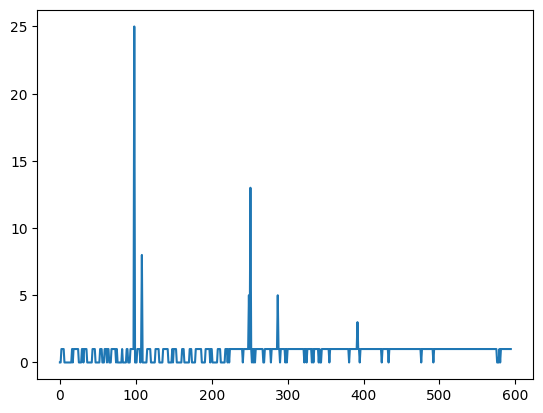

In [ ]:
# plt.plot(selected_move_by_ucb.children_prior_probabilities)
# plt.plot(root_network_eval_result.policy)
plt.plot(selected_move_to_play.children_visit_counts)